### データの読み込み
表形式のデータを扱うのに長けた，pandasでデータを読み込む。
pandasにはread_csv()やread_excel()関数があり，一般的な表形式データをそのまま読み込むことができる。

In [2]:
import pandas as pd
df = pd.read_csv("./CarPrice_Assignment.csv")

Jupyter Notebook形式でスクリプトを書いている場合，セルの最終行に変数名だけを記載した場合，その内容が表示される。
その他の場所で表示がしたい場合はprint()関数の使用が必要

In [3]:
df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


## データの整形
ダウンロードしたままの形出は，ニューラルネットワークへ直接入力を行うことができない。ここでは入力できる形へデータを整形する。

## 予測に意味をなさないデータの除外
読み込んだデータには，車の名称など，直接的に価格に結びつきにくいデータが含まれている。そういったデータを除外する。

※言語モデルを用いて「ポルシェだから高そう」や「高級そうな車種名だ」といった情報を加えたい場合，話は別
※単純に数値かする上でも，車種名を省いてメーカー名のみ抽出すれば情報として有意義かもしれない

In [4]:
# 学習から除外する列を指定
drop_columns = ["car_ID", "CarName"]

# dfをコピー
df_buf = df.drop(drop_columns, axis=1)

### 文字列で記録されたデータの数値化
読みこんだデータには，文字列が多分に含まれている。先週扱った通り，ニューラルネットワークは「数値（数は問わない）」を入力して「数値（数は問わない）」を出力する。従って，例えば燃料タイプの"gas"や"diesel"は，何かしらの数値へ変換する必要がある。ここでは，アルファベット順にソートした名称順に0,1,2...と数値化を行う。

In [5]:
# 列に対してループ
for column in df_buf.columns:
    
    # 列名称とデータ型を表示
    print(f"-----------------------------------------")
    print(f"col name: {column}, dtype: {df_buf[column].dtype}")

    # ユニークな値のリストを表示
    print(f"unique values:{df_buf[column].unique()}")
    
    # object型の列に対しては，ユニークな値を0始まりの整数に置換
    if df_buf[column].dtype == "object":
        df_buf[column] = pd.Categorical(df[column])
        df_buf[column] = df_buf[column].cat.codes
        print(f"convert:{df_buf[column].unique()}")


-----------------------------------------
col name: symboling, dtype: int64
unique values:[ 3  1  2  0 -1 -2]
-----------------------------------------
col name: fueltype, dtype: object
unique values:['gas' 'diesel']
convert:[1 0]
-----------------------------------------
col name: aspiration, dtype: object
unique values:['std' 'turbo']
convert:[0 1]
-----------------------------------------
col name: doornumber, dtype: object
unique values:['two' 'four']
convert:[1 0]
-----------------------------------------
col name: carbody, dtype: object
unique values:['convertible' 'hatchback' 'sedan' 'wagon' 'hardtop']
convert:[0 2 3 4 1]
-----------------------------------------
col name: drivewheel, dtype: object
unique values:['rwd' 'fwd' '4wd']
convert:[2 1 0]
-----------------------------------------
col name: enginelocation, dtype: object
unique values:['front' 'rear']
convert:[0 1]
-----------------------------------------
col name: wheelbase, dtype: float64
unique values:[ 88.6  94.5  99

## データの数値レンジの正規化
今回のデータにおいては，燃料タイプは0-1で，重量は2548-3062の範囲で分布している。
これらのデータの最大値と最小値の差は，1と514で，このままモデルに入力を行った場合，このバランスを取るために訓練のリソース消費される。
意図的に何かのデータを重視したい場合を除いては，これらの値は同じスケールに統一したほうがよい。
そういった処理としてMin-Max normalization という，最小値を0，最大値を1で統一する正規化手法が存在する。

In [6]:
for column in df_buf.columns:
    print(f"col name: {column}, min: {df_buf[column].min()}, max: {df_buf[column].max()}")
    df_buf[column] = (df_buf[column] - df_buf[column].min()) / (df_buf[column].max() - df_buf[column].min())

col name: symboling, min: -2, max: 3
col name: fueltype, min: 0, max: 1
col name: aspiration, min: 0, max: 1
col name: doornumber, min: 0, max: 1
col name: carbody, min: 0, max: 4
col name: drivewheel, min: 0, max: 2
col name: enginelocation, min: 0, max: 1
col name: wheelbase, min: 86.6, max: 120.9
col name: carlength, min: 141.1, max: 208.1
col name: carwidth, min: 60.3, max: 72.3
col name: carheight, min: 47.8, max: 59.8
col name: curbweight, min: 1488, max: 4066
col name: enginetype, min: 0, max: 6
col name: cylindernumber, min: 0, max: 6
col name: enginesize, min: 61, max: 326
col name: fuelsystem, min: 0, max: 7
col name: boreratio, min: 2.54, max: 3.94
col name: stroke, min: 2.07, max: 4.17
col name: compressionratio, min: 7.0, max: 23.0
col name: horsepower, min: 48, max: 288
col name: peakrpm, min: 4150, max: 6600
col name: citympg, min: 13, max: 49
col name: highwaympg, min: 16, max: 54
col name: price, min: 5118.0, max: 45400.0


In [7]:
df_buf

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1.0,1.0,0.0,1.0,0.00,1.0,0.0,0.058309,0.413433,0.316667,...,0.260377,0.714286,0.664286,0.290476,0.12500,0.262500,0.346939,0.222222,0.289474,0.207959
1,1.0,1.0,0.0,1.0,0.00,1.0,0.0,0.058309,0.413433,0.316667,...,0.260377,0.714286,0.664286,0.290476,0.12500,0.262500,0.346939,0.222222,0.289474,0.282558
2,0.6,1.0,0.0,1.0,0.50,1.0,0.0,0.230321,0.449254,0.433333,...,0.343396,0.714286,0.100000,0.666667,0.12500,0.441667,0.346939,0.166667,0.263158,0.282558
3,0.8,1.0,0.0,0.0,0.75,0.5,0.0,0.384840,0.529851,0.491667,...,0.181132,0.714286,0.464286,0.633333,0.18750,0.225000,0.551020,0.305556,0.368421,0.219254
4,0.8,1.0,0.0,0.0,0.75,0.0,0.0,0.373178,0.529851,0.508333,...,0.283019,0.714286,0.464286,0.633333,0.06250,0.279167,0.551020,0.138889,0.157895,0.306142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.2,1.0,0.0,0.0,0.75,1.0,0.0,0.655977,0.711940,0.716667,...,0.301887,0.714286,0.885714,0.514286,0.15625,0.275000,0.510204,0.277778,0.315789,0.291123
201,0.2,1.0,1.0,0.0,0.75,1.0,0.0,0.655977,0.711940,0.708333,...,0.301887,0.714286,0.885714,0.514286,0.10625,0.466667,0.469388,0.166667,0.236842,0.345738
202,0.2,1.0,0.0,0.0,0.75,1.0,0.0,0.655977,0.711940,0.716667,...,0.422642,0.714286,0.742857,0.380952,0.11250,0.358333,0.551020,0.138889,0.184211,0.406311
203,0.2,0.0,1.0,0.0,0.75,1.0,0.0,0.655977,0.711940,0.716667,...,0.316981,0.428571,0.335714,0.633333,1.00000,0.241667,0.265306,0.361111,0.289474,0.430763


## データを訓練・テストに分割
データ全てを使って訓練すると，過学習（問題集の丸暗記に近い状態）となり，初めて見るデータに対する推測性能を知ることができない。
整形したデータの２割を，テストデータ，８割を訓練データとして分割する。

In [8]:
# 価格を予測するため，price列をyとして分ける
from sklearn.model_selection import train_test_split
X = df_buf.drop("price", axis=1)
y = df_buf["price"]

# 分割の再現性を確保するため，シード値を指定したうえで訓練データ・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [9]:
X_train

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
4,0.8,1.0,0.0,0.0,0.75,0.0,0.0,0.373178,0.529851,0.508333,...,0.166667,0.283019,0.714286,0.464286,0.633333,0.06250,0.279167,0.551020,0.138889,0.157895
71,0.2,1.0,0.0,0.0,0.75,1.0,0.0,0.845481,0.917910,0.950000,...,0.000000,0.652830,0.714286,0.657143,0.490476,0.08125,0.445833,0.244898,0.083333,0.052632
134,1.0,1.0,0.0,1.0,0.50,0.5,0.0,0.364431,0.679104,0.516667,...,0.333333,0.226415,0.714286,0.000000,0.000000,0.14375,0.258333,0.448980,0.222222,0.315789
145,0.4,1.0,1.0,0.0,0.75,0.0,0.0,0.303207,0.461194,0.425000,...,0.333333,0.177358,0.714286,0.771429,0.271429,0.04375,0.262500,0.265306,0.305556,0.342105
122,0.6,1.0,0.0,0.0,0.75,0.5,0.0,0.206997,0.391045,0.291667,...,0.333333,0.139623,0.142857,0.307143,0.552381,0.15000,0.083333,0.551020,0.500000,0.578947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.2,0.0,1.0,0.0,0.75,1.0,0.0,0.682216,0.743284,0.833333,...,0.166667,0.460377,0.428571,0.742857,0.747619,0.90625,0.312500,0.081633,0.250000,0.236842
192,0.4,0.0,1.0,0.0,0.75,0.5,0.0,0.402332,0.583582,0.550000,...,0.333333,0.135849,0.428571,0.335714,0.633333,1.00000,0.083333,0.142857,0.555556,0.578947
117,0.4,1.0,1.0,0.0,0.75,1.0,0.0,0.623907,0.680597,0.666667,...,0.333333,0.275472,0.714286,0.764286,0.542857,0.00000,0.391667,0.591837,0.138889,0.210526
47,0.4,1.0,0.0,0.0,0.75,1.0,0.0,0.769679,0.873134,0.775000,...,0.500000,0.743396,0.714286,0.778571,1.000000,0.06875,0.533333,0.244898,0.055556,0.078947


In [10]:
X_test

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
52,0.6,1.0,0.0,1.0,0.50,0.5,0.0,0.189504,0.268657,0.325000,...,0.333333,0.113208,0.142857,0.350000,0.514286,0.12500,0.083333,0.346939,0.500000,0.578947
181,0.2,1.0,0.0,0.0,1.00,1.0,0.0,0.521866,0.697015,0.516667,...,0.500000,0.377358,0.714286,0.521429,0.609524,0.13750,0.450000,0.428571,0.166667,0.210526
5,0.8,1.0,0.0,1.0,0.75,0.5,0.0,0.384840,0.540299,0.500000,...,0.166667,0.283019,0.714286,0.464286,0.633333,0.09375,0.258333,0.551020,0.166667,0.236842
18,0.8,1.0,0.0,1.0,0.50,0.5,0.0,0.052478,0.000000,0.000000,...,0.666667,0.000000,0.142857,0.264286,0.457143,0.15625,0.000000,0.387755,0.944444,0.973684
188,0.8,1.0,0.0,0.0,0.75,0.5,0.0,0.311953,0.456716,0.433333,...,0.333333,0.181132,0.714286,0.464286,0.633333,0.18750,0.216667,0.551020,0.361111,0.421053
170,0.8,1.0,0.0,1.0,0.25,1.0,0.0,0.344023,0.523881,0.441667,...,0.333333,0.320755,0.714286,0.771429,0.680952,0.14375,0.283333,0.265306,0.305556,0.368421
76,0.8,1.0,0.0,1.0,0.50,0.5,0.0,0.206997,0.241791,0.341667,...,0.333333,0.116981,0.142857,0.307143,0.552381,0.15000,0.083333,0.551020,0.666667,0.657895
154,0.4,1.0,0.0,0.0,1.00,0.0,0.0,0.265306,0.426866,0.275000,...,0.333333,0.116981,0.142857,0.364286,0.457143,0.12500,0.058333,0.265306,0.388889,0.421053
104,1.0,1.0,0.0,1.0,0.50,1.0,0.0,0.137026,0.441791,0.633333,...,0.500000,0.452830,0.714286,0.635714,0.571429,0.12500,0.466667,0.428571,0.166667,0.236842
33,0.6,1.0,0.0,1.0,0.50,0.5,0.0,0.206997,0.132836,0.308333,...,0.333333,0.116981,0.000000,0.264286,0.638095,0.13750,0.116667,0.755102,0.472222,0.473684


In [11]:
y_train

4      0.306142
71     0.721563
134    0.246313
145    0.152450
122    0.061839
         ...   
67     0.507274
192    0.216648
117    0.323519
47     0.673551
172    0.311578
Name: price, Length: 164, dtype: float64

In [12]:
y_test

52     0.041631
181    0.263939
5      0.251527
18     0.000819
188    0.121071
170    0.150961
76     0.006728
154    0.069013
104    0.299911
33     0.035028
12     0.393526
129    0.652463
55     0.144655
66     0.328335
45     0.094298
169    0.120922
130    0.103694
7      0.342634
37     0.068939
152    0.034010
80     0.120178
111    0.259719
131    0.118589
171    0.159649
179    0.270096
138    0.000000
156    0.045181
113    0.287399
161    0.080433
89     0.009458
183    0.070925
193    0.178045
125    0.419542
173    0.095080
92     0.042972
16     0.898590
189    0.160791
136    0.323519
22     0.031255
74     1.000000
44     0.094298
Name: price, dtype: float64

## データをpytorch用に変換
データを変換し，モデルが読み込めるようにデータローダーを定義する。

In [13]:
# torchテンソルに変換
import torch
X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

# データローダー定義用に変換
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# データローダー定義
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=23, shuffle=False)


In [14]:
for batch, (X, y) in enumerate(train_loader):
    print(f"batch: {batch}, X: {X.shape}, y: {y.shape}")

batch: 0, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 1, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 2, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 3, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 4, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 5, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 6, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 7, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 8, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 9, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 10, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 11, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 12, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 13, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 14, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 15, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 16, X: torch.Size([4, 23]), y: torch.Size([4, 1])
batch: 17, X: torch.Size([4, 23]), y: tor

## モデルの定義
モデルの定義自体は基本的に前回の分類問題と同様。
変更するのは，入出力データのサイズ。

### 前回の入出力サイズ
入力：縦横28ピクセルのモノクロ画像データのため，１ピクセル毎の輝度データが入力，つまり28×28=784個の数値を入力とした。
出力：10種類の衣類の種類それぞれの確率を数字としたため，10個の数字が出力

### 今回の入出力サイズ
入力：23列の各パラメータが対応するため，数値23個を入力する。
出力：価格，つまり単一の数値が出力


In [15]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(input_size=23, output_size=1).to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=23, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): ReLU()
  )
)


## 訓練条件の指定
損失関数，最適化アルゴリズムを指定する。
前回と違うのは，損失関数が単純に数値の誤差のため，MSELoss()を使用する点


In [16]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        current = batch * len(X)
    total_loss /= size
    total_error = total_loss**0.5

    return total_error

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= size
    test_error = test_loss**0.5

    return test_error

In [18]:
epochs = 100
train_error = []; test_error = []

import tqdm
for t in tqdm.tqdm(range(epochs)):
    train_error.append(train(train_loader, model, loss_fn, optimizer))
    test_error.append(test(test_loader, model))
print("完了")

100%|██████████| 100/100 [00:06<00:00, 15.88it/s]

完了


## 学習曲線の可視化

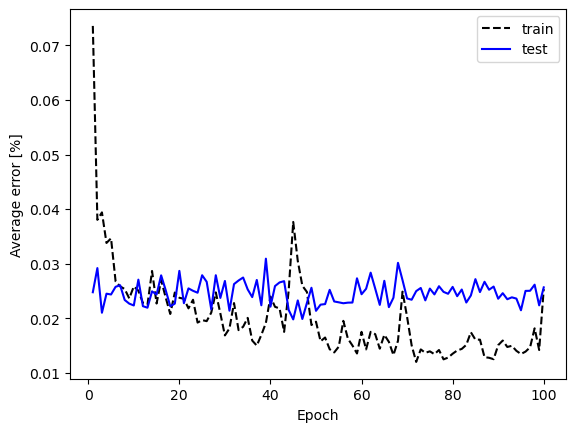

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(1,epochs+1), train_error, label="train", color="black", linestyle="dashed")
plt.plot(range(1,epochs+1), test_error, label="test", color="blue")
#日本語フォントを設定
plt.xlabel("Epoch")
plt.ylabel("Average error [%]")
plt.legend()
plt.show()
